In [27]:
# from google.colab import files

# - POLIST_13_gpb_datas.csv
# - POLIST_00_graph_analysis.py
# files.upload()

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from POLIST_00_graph_analysis import segmentation

pd.set_option("display.max_columns", None)

raw_datas = pd.read_csv("POLIST_13_gpb_datas.csv")
raw_datas

,customer_unique_id,customer_state,nb_score_sum,pay_sum_sum,nb_product_sum_sum,type_boleto_sum,type_credit_card_sum,type_debit_card_sum,type_voucher_sum,category__agro_industry_and_commerce_sum,category__air_conditioning_sum,category__art_sum,category__arts_and_craftmanship_sum,category__audio_sum,category__auto_sum,category__baby_sum,category__bed_bath_table_sum,category__books_general_interest_sum,category__books_imported_sum,category__books_technical_sum,category__cds_dvds_musicals_sum,category__christmas_supplies_sum,category__cine_photo_sum,category__computers_sum,category__computers_accessories_sum,category__consoles_games_sum,category__construction_tools_construction_sum,category__construction_tools_lights_sum,category__construction_tools_safety_sum,category__cool_stuff_sum,category__costruction_tools_garden_sum,category__costruction_tools_tools_sum,category__diapers_and_hygiene_sum,category__drinks_sum,category__dvds_blu_ray_sum,category__electronics_sum,category__fashio_female_clothing_sum,category__fashion_bags_accessories_sum,category__fashion_childrens_clothes_sum,category__fashion_male_clothing_sum,category__fashion_shoes_sum,category__fashion_sport_sum,category__fashion_underwear_beach_sum,category__fixed_telephony_sum,category__flowers_sum,category__food_sum,category__food_drink_sum,category__furniture_bedroom_sum,category__furniture_decor_sum,category__furniture_living_room_sum,category__furniture_mattress_and_upholstery_sum,category__garden_tools_sum,category__health_beauty_sum,category__home_appliances_sum,category__home_appliances_2_sum,category__home_comfort_2_sum,category__home_confort_sum,category__home_construction_sum,category__housewares_sum,category__industry_commerce_and_business_sum,category__kitchen_dining_laundry_garden_furniture_sum,category__kitchen_laptops_and_food_preparers_sum,category__la_cuisine_sum,category__luggage_accessories_sum,category__market_place_sum,category__music_sum,category__musical_instruments_sum,category__office_furniture_sum,category__others_sum,category__party_supplies_sum,category__pc_gamer_sum,category__perfumery_sum,category__pet_shop_sum,category__security_and_services_sum,category__signaling_and_security_sum,category__small_appliances_sum,category__small_appliances_home_oven_and_coffee_sum,category__sports_leisure_sum,category__stationery_sum,category__tablets_printing_image_sum,category__telephony_sum,category__toys_sum,category__watches_gifts_sum,seller_state__AC_sum,seller_state__AM_sum,seller_state__BA_sum,seller_state__CE_sum,seller_state__DF_sum,seller_state__ES_sum,seller_state__GO_sum,seller_state__MA_sum,seller_state__MG_sum,seller_state__MS_sum,seller_state__MT_sum,seller_state__PA_sum,seller_state__PB_sum,seller_state__PE_sum,seller_state__PI_sum,seller_state__PR_sum,seller_state__RJ_sum,seller_state__RN_sum,seller_state__RO_sum,seller_state__RS_sum,seller_state__SC_sum,seller_state__SE_sum,seller_state__SP_sum,days_last_purchase_min,frequency,init_score_mean,delivering_time_mean
0,7c396fd4830fd04220f754e42b4e5bff,SP,2,82.82,2,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,331,2,4.5,4.5
1,af07308b275d755c9edb36a90c618231,BA,1,141.46,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,36,1,4.0,12.0
2,3a653a41f6f9fc3d2a113cf8398680e8,GO,1,179.12,1,0.0,1.0,0.0,0

In [29]:
for col in raw_datas.columns:
    nb_null = raw_datas[col].isnull().sum()
    if nb_null > 0:
        print(f"{col} => {nb_null}")

delivering_time_mean => 21


In [30]:
raw_datas["delivering_time_mean"].fillna(-10**3, inplace= True)
for col in raw_datas.columns:
    nb_null = raw_datas[col].isnull().sum()
    if nb_null > 0:
        print(f"{col} => {nb_null}")

In [31]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

datas_num_cols = []
datas_cat_cols = ["customer_state"]
# for col in raw_datas.columns:
#     if raw_datas[col].dtypes != np.object_:
#         datas_num_cols.append(col)
#     else:
#         datas_cat_cols.append(col)

ct = ColumnTransformer([
    # ("scaler", StandardScaler(), datas_num_cols),
    ("encoding", OrdinalEncoder(), datas_cat_cols)
])

X_enc = pd.DataFrame(ct.fit_transform(raw_datas), columns= datas_cat_cols, 
                     index= raw_datas.index)

In [32]:
other_cols = [x for x in raw_datas.columns if x not in ["customer_unique_id", "customer_state"]]

X = pd.concat([X_enc, raw_datas[other_cols]], axis= 1)

In [33]:
samples = np.random.choice(X.index, int(len(X) * 0.3), replace= False)
X_samples = X.iloc[samples, :]
X_samples.shape

(27849, 109)

Il faut que je commence par trouver l'EPS optimal pour le DBSCAN.
Pour se faire, je vais utiliser la méthode du coude.

In [34]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors= 2)
nbrs = neigh.fit(X_samples)
distances, indices = nbrs.kneighbors(X_samples)

In [35]:
print(f"Dist: {distances[1]}  -  Ind: {indices[1]}")

Dist: [0.         3.76382784]  -  Ind: [    1 13966]


In [36]:
distances = np.sort(distances, axis= 0)
distances = distances[:, 1]
distances

array([  0.        ,   0.        ,   0.        , ..., 569.91970803,
       894.4288529 , 894.4288529 ])

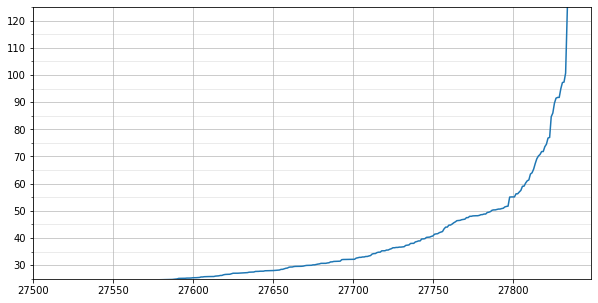

In [37]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

plt.plot(distances)

plt.xlim(27500, len(distances))
plt.ylim(25, 125)

ax.set_yticks(np.arange(25, 126, 5), minor= True)
ax.set_yticks(np.arange(30, 125, 10))
ax.grid(which= "minor", alpha= 0.3)
ax.grid(which= "major", alpha= 0.8)

plt.show()

L' EPS optimal semble être environ 50.

Je tente avec min_sample= 5, 10, 15, 20.

In [38]:
# from sklearn.cluster import DBSCAN
# from sklearn.metrics import silhouette_score

# min_samples = [5, 10, 15, 20]

# results_list = []
# for min_sample in min_samples:
#   clustering = DBSCAN(min_samples= min_sample, eps= 50).fit(X_samples)

#   clusters = len(np.unique(clustering.labels_)) -1
#   sil_score = silhouette_score(X_samples, clustering.labels_)
#   excluded = np.sum(clustering.labels_ == -1, axis= 0)
#   perc = np.round(excluded / len(X_samples), 3) *100

#   results_list.append([clusters, min_sample, sil_score, excluded, 
#                        perc])


In [39]:
# clusters_df = pd.DataFrame(results_list, columns= ["clusters", "min_samples", 
#                           "sil_score", "nb_excluded", "perc_excluded"])
# clusters_df

Je choisis min_samples= 10. En effet, ce n'est pas le min_sample (15) avec le silhouette score le plus optimal (0.427) néanmoins, il m'offre un nombre de clusters acceptable (7 clusters) pour un silhouette score de 0.400 et un bruit relativement bas (1.1%de données)

Visualisons les données.

In [40]:
labels = pd.DataFrame(DBSCAN(min_samples= 10, eps= 50).fit_predict(X_samples), 
                      columns= ["labels"], 
                      index= X_samples.index)

In [41]:
X_samples["labels"] = labels["labels"].copy()
X_samples = X_samples[X_samples["labels"] > -1].copy()

C:\Users\nanar\AppData\Local\Temp/ipykernel_8624/1765116031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_samples["labels"] = labels["labels"].copy()


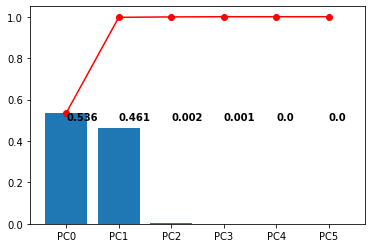

In [42]:
from sklearn.decomposition import PCA

cols = [x for x in X_samples.columns if x not in "labels"]

components = 6

pca = PCA(n_components= components)
pca.fit(X_samples[cols])

X_pca = pd.DataFrame(pca.transform(X_samples[cols]))

expl_var_ratio = pca.explained_variance_ratio_
var_cumsum = expl_var_ratio.cumsum()

plt.bar(["PC" + str(x) for x in range(len(expl_var_ratio))], expl_var_ratio)
plt.plot(["PC" + str(x) for x in range(len(var_cumsum))], var_cumsum, "ro-")

for num, evr in enumerate(expl_var_ratio):
    plt.text(num, 0.5, str(np.round(evr, 3)), fontweight= "bold")

plt.show()

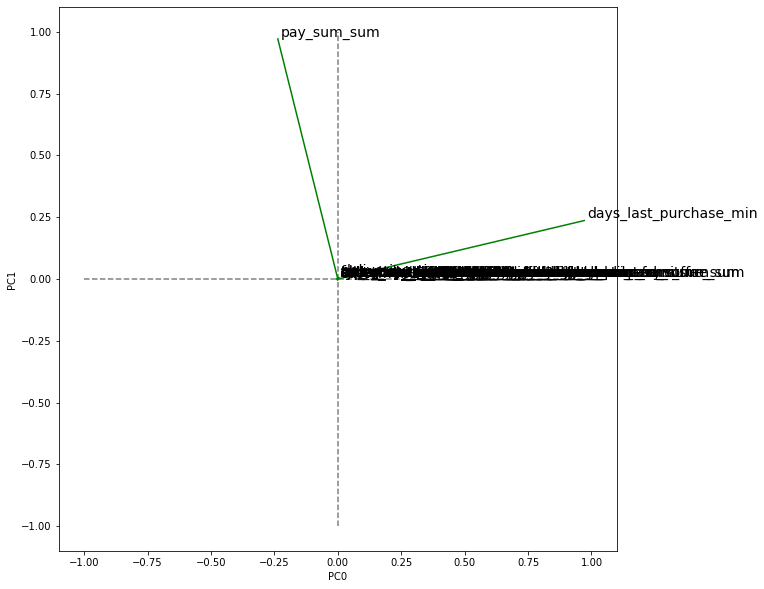

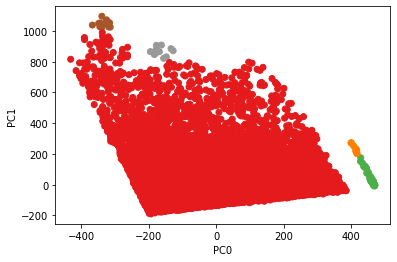

In [43]:
fig = plt.figure(figsize=(10, 10))
plt.plot([-1, 1], [0, 0], color= "grey", ls="--")
plt.plot([0, 0], [-1, 1], color= "grey", ls="--")

for i, (x, y) in enumerate(zip(pca.components_.T[:, 0], pca.components_.T[:, 1])):
    plt.plot([0, x], [0, y], color= "g", ls= "-")
    plt.text(x + 0.01, y + 0.01, X.columns[i], fontsize= 14)

plt.xlabel("PC0")
plt.ylabel("PC1")

plt.show()

plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c= X_samples["labels"], cmap= "Set1")

plt.xlabel("PC0")
plt.ylabel("PC1")

plt.show()


In [47]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components= 2, learning_rate= "auto").fit_transform(X_pca)


C:\Users\nanar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [48]:
print(X_tsne.shape)
X_tsne

(27545, 2)


array([[ -50.192013 ,   12.108148 ],
       [ -33.04957  , -100.87201  ],
       [ -32.483807 ,   14.032034 ],
       ...,
       [ -35.472874 ,  -88.03374  ],
       [ -44.143623 ,   61.835773 ],
       [  97.72253  ,   -4.2545886]], dtype=float32)

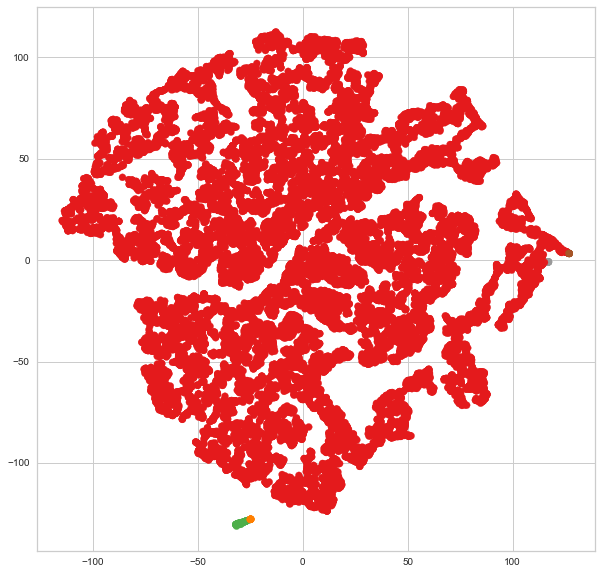

In [52]:
fig = plt.figure(figsize=(10, 10))

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c= X_samples["labels"], cmap= "Set1")

plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X_df = raw_datas.iloc[samples, :].copy()
X_df["labels"] = labels["labels"]

X_df = X_df[X_df["labels"] > -1]

X_cust = X_df.customer_state.to_numpy().reshape(-1, 1)
ohe = OneHotEncoder().fit(X_cust)

X_ohe = pd.DataFrame(ohe.transform(X_cust).toarray(), columns= ohe.get_feature_names_out(["customer_state__"]), index= X_df.index)

X_dff = X_df.merge(X_ohe, left_index= True, right_index= True)
X_dff.drop("customer_state", axis= 1, inplace= True)


In [ ]:
segments_names = ["cluster_" + str(x) for x in np.sort(X_dff["labels"].unique())]
conditions = [labels["labels"] == x for x in np.sort(X_dff["labels"].unique())]

segments = segmentation(X_dff, conditions, segments_names)
segments

/content/POLIST_00_graph_analysis.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  segment_datas = datas[condition]


,segment_name,nb_clients,perc_clients,payment_mean_value,montant_CA,perc_CA,buyed_prod_mean,prod_price_mean,buyed_prod_nb,perc_buyed_prod_nb,perc_boleto_payment,perc_credit_card_payment,perc_debit_card_payment,perc_voucher_payment,best_cat_1,perc_best_cat_1,best_cat_2,perc_best_cat_2,best_cat_3,perc_best_cat_3,worst_cat_1,perc_worst_cat_1,worst_cat_2,perc_worst_cat_2,worst_cat_3,perc_worst_cat_3,mean_last_purchase_day,mean_frequency,mean_scores,best_cust_state,relat_perc_best_cust_state,abs_perc_best_cust_state,worst_cust_state,relat_perc_worst_cust_state,abs_perc_worst_cust_state
0,cluster_0,27411,99.5,148.09,4059184.07,97.5,1.16,127.66,31915,99.4,19.1,74.2,1.5,5.2,bed bath table,10.2,health beauty,9.0,sports leisure,7.8,cds dvds musicals,0.0,security and services,0.0,pc gamer,0.0,235.6,1.0,4.2,SP,42.3,42.1,RR,0.0,0.0
1,cluster_1,59,0.2,99.10,5846.82,0.1,1.08,91.76,64,0.2,12.9,79.0,3.2,4.8,furniture decor,23.7,health beauty,10.2,computers accessories,8.5,agro industry and commerce,0.0,fixed telephony,0.0,flowers,0.0,691.2,1.0,3.6,SP,39.0,0.1,TO,0.0,0.0
2,cluster_2,21,0.1,1061.75,22296.83,0.5,1.38,769.38,29,0.1,13.6,81.8,0.0,4.5,health beauty,13.6,musical instruments,13.6,consoles games,13.6,agro industry and commerce,0.0,toys,0.0,food drink,0.0,308.2,1.0,3.9,SP,42.9,0.0,TO,0.0,0.0
3,cluster_3,14,0.1,1238.05,17332.67,0.4,1.14,1086.01,16,0.0,27.8,66.7,0.0,5.6,computers,43.8,fashion bags accessories,18.8,health beauty,18.8,agro industry and commerce,0.0,la cuisine,0.0,kitchen laptops and food preparers,0.0,374.9,1.1,4.6,RJ,28.6,0.0,AC,0.0,0.0
4,cluster_4,28,0.1,1172.56,32831.59,0.8,1.89,620.40,53,0.2,16.2,75.7,0.0,8.1,watches gifts,16.2,baby,13.5,housewares,10.8,agro industry and commerce,0.0,fashion shoes,0.0,fashion sport,0.0,149.9,1.2,3.6,SP,39.3,0.0,TO,0.0,0.0
5,cluster_5,7,0.0,1040.41,7282.85,0.2,1.86,559.36,13,0.0,20.0,60.0,0.0,20.0,watches gifts,12.5,perfumery,12.5,furniture living room,12.5,agro industry and commerce,0.0,toys,0.0,food drink,0.0,63.0,1.1,3.7,SP,28.6,0.0,TO,0.0,0.0
6,cluster_6,14,0.1,1368.58,19160.12,0.5,1.93,709.11,27,0.1,26.7,66.7,6.7,0.0,health beauty,26.7,auto,20.0,housewares,20.0,agro industry and commerce,0.0,toys,0.0,food drink,0.0,50.7,1.1,4.2,MG,35.7,0.0,TO,0.0,0.0


1. Le ***cluster 0*** représentent 99.5% des clients. En moyenne, ils achètent 1.16 articles au prix moyen de 127.66, soit un panier moyen de 148.09. Ils participent à hauteur de 97.5% du CA total et payent majoritairement par carte de crédit (74.2%) et par boleto (19.1%). Leurs catégories préférées sont "bed bath table" (10.2%), "health beauty" (9.0%) et "sports leisure" (7.8%). Ces clients ont passé en moyenne 1.0 commandes dont la dernière a eu lieu il y a en moyenne 235.6 jours à la date de l'analyse. Ces clients proviennent à 42.3% de l'état "SP". Ils ont donné un score moyen de 4.2 étoiles.
2. Le ***cluster 1*** représentent 0.2% des clients. En moyenne, ils achètent 1.08 articles au prix moyen de 91.76, soit un panier moyen de 99.10. Ils participent à hauteur de 0.1% du CA total et payent majoritairement par carte de crédit (79.0%) et par boleto (12.9%). Leurs catégories préférées sont "furniture decor" (23.7%), "health beauty" (10.2%) et "computers accessories" (8.5%). Ces clients ont passé en moyenne 1.0 commandes dont la dernière a eu lieu il y a en moyenne 691.2 jours à la date de l'analyse. Ces clients proviennent à 39.0% de l'état "SP". Ils ont donné un score moyen de 3.6 étoiles.
3. Le ***cluster 2*** représentent 0.1% des clients. En moyenne, ils achètent 1.38 articles au prix moyen de 769.38, soit un panier moyen de 1061.75. Ils participent à hauteur de 0.5% du CA total et payent majoritairement par carte de crédit (81.8%) et par boleto (13.6%). Leurs catégories préférées sont "health beauty " (13.6%), "musical instruments" (13.6%) et "consoles games" (13.6%). Ces clients ont passé en moyenne 1.0 commandes dont la dernière a eu lieu il y a en moyenne 308.2 jours à la date de l'analyse. Ces clients proviennent à 42.9% de l'état "SP". Ils ont donné un score moyen de 3.9 étoiles.
4. Le ***cluster 3*** représentent 0.1% des clients. En moyenne, ils achètent 1.14 articles au prix moyen de 1086.01, soit un panier moyen de 1238.05. Ils participent à hauteur de 0.4% du CA total et payent majoritairement par carte de crédit (66.7%) et par boleto (27.8%). Leurs catégories préférées sont "computers" (43.8%), "fashion bags accessories" (18.8%) et "health beauty" (18.8%). Ces clients ont passé en moyenne 1.1 commandes dont la dernière a eu lieu il y a en moyenne 374.9 jours à la date de l'analyse. Ces clients proviennent à 28.6% de l'état "RJ". Ils ont donné un score moyen de 4.6 étoiles.
5. Le ***cluster 4*** représentent 0.1% des clients. En moyenne, ils achètent 1.89 articles au prix moyen de 620.40, soit un panier moyen de 1172.56. Ils participent à hauteur de 0.8% du CA total et payent majoritairement par carte de crédit (75.7%) et par boleto (16.2%). Leurs catégories préférées sont "watches gifts" (16.2%), "baby" (13.5%) et "housewares" (10.8%). Ces clients ont passé en moyenne 1.2 commandes dont la dernière a eu lieu il y a en moyenne 149.9 jours à la date de l'analyse. Ces clients proviennent à 39.3% de l'état "SP". Ils ont donné un score moyen de 3.6 étoiles.
6. Le ***cluster 5*** représentent 0.0% des clients. En moyenne, ils achètent 1.86 articles au prix moyen de 559.36, soit un panier moyen de 1040.41. Ils participent à hauteur de 0.2% du CA total et payent majoritairement par carte de crédit (60.0%) puis par boleto et voucher de manière égale (20.0%). Leurs catégories préférées sont "watches gifts" (12.5%), "perfumery" (12.5%) et "furnitures living room" (12.5%). Ces clients ont passé en moyenne 1.1 commandes dont la dernière a eu lieu il y a en moyenne 63.0 jours à la date de l'analyse. Ces clients proviennent à 28.6% de l'état "SP". Ils ont donné un score moyen de 3.7 étoiles.
7. Le ***cluster 6*** représentent 0.1% des clients. En moyenne, ils achètent 1.93 articles au prix moyen de 709.11, soit un panier moyen de 1368.58. Ils participent à hauteur de 0.5% du CA total et payent majoritairement par carte de crédit (66.7%) et par boleto (26.7%). Leurs catégories préférées sont "health beauty" (26.7%), "auto" (20.0%) et "housewares" (20.0%). Ces clients ont passé en moyenne 1.1 commandes dont la dernière a eu lieu il y a en moyenne 50.7 jours à la date de l'analyse. Ces clients proviennent à 35.7% de l'état "MG". Ils ont donné un score moyen de 4.2 étoiles.